In [39]:
# Standard modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import validation_curve, ShuffleSplit
from sklearn.metrics import explained_variance_score, make_scorer
from sklearn.svm import SVR

# Custom modules
from jpm_time_conversions import *
from jpm_logger import JpmLogger

__author__ = 'James Paul Mason'
__contact__ = 'jmason86@gmail.com'


def automatic_fit_coronal_dimming_light_curve(light_curve_df, minimum_score=0.3, plots_save_path=None, verbose=False):
    """Automatically fit the best support vector machine regression (SVR) model for the input light curve.

    Inputs:
        light_curve_df [pd DataFrame]: A pandas DataFrame with a DatetimeIndex, and columns for intensity and uncertainty.

    Optional Inputs:
        minimum_score [float]: Set this to the minimum explained variance score (0 - 1) acceptable for fits. If the 
                               best fit score is < minimum_score, this function will return None for light_curve_fit. 
                               Default value is 0.3.
        plots_save_path [str]: Set to a path in order to save the validation curve and best fit overplot on the data to disk.
                               Default is None, meaning no plots will be saved to disk.
        verbose [bool]:        Set to log the processing messages to disk and console. Default is False.

    Outputs:
        light_curve_fit_df [pd DataFrame]: A pandas DataFrame with a DatetimeIndex, and columns for fitted intensity and uncertainty.
        best_fit_gamma [float]:            The best found gamma hyper parameter for the SVR. 
        best_fit_score [float]:            The best explained variance score. 

    Optional Outputs:
        None

    Example:
        light_curve_fit, best_fit_gamma, best_fit_score = automatic_fit_coronal_dimming_light_curve(light_curve_df, verbose=True)
    """
    return 1

In [40]:
# prototype only: load some example dimming light curve data
minimum_score = 0.3
plots_save_path='./'
verbose = True
from scipy.io.idl import readsav
idl_generated_data = readsav('/Users/jmason86/Dropbox/Research/Postdoc_NASA/Analysis/Coronal Dimming Analysis/Example Dimming Light Curve.sav')
from calculate_eve_fe_line_precision import calculate_eve_fe_line_precision
uncertainty = calculate_eve_fe_line_precision()[3] * 100. + np.zeros(len(idl_generated_data.yyyydoy)) # * 100 for [%]
light_curve_df = pd.DataFrame({'irradiance': idl_generated_data.irradiance[:, 3],
                               'uncertainty': uncertainty})
light_curve_df.index = yyyydoy_sod_to_datetime(idl_generated_data.yyyydoy, idl_generated_data.sod) # Convert EVE to datetime
light_curve_df.head()

,irradiance,uncertainty
2012-04-15 17:43:20,0.246831,0.160099
2012-04-15 17:43:25,0.399922,0.160099
2012-04-15 17:43:30,0.275836,0.160099
2012-04-15 17:43:35,0.319487,0.160099
2012-04-15 17:43:40,0.920058,0.160099


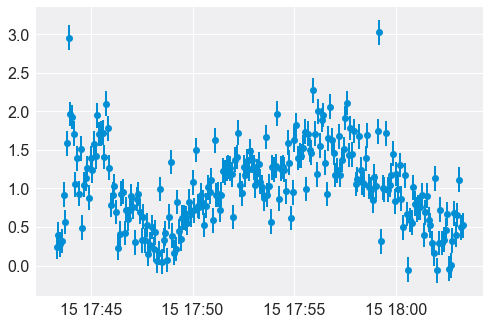

In [41]:
# prototype only: just taking a look at the data
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('jpm-light')
plt.errorbar(light_curve_df.index, light_curve_df['irradiance'], yerr=light_curve_df['uncertainty'], fmt='o');

In [42]:
# Prepare the logger for verbose
if verbose:
    # TODO: Update the path
    logger = JpmLogger(filename='automatic_fit_coronal_dimming_light_curve_log', path='/Users/jmason86/Desktop/')

# Pull data out of the DataFrame for compatibility formatting
X = metatimes_to_seconds_since_start(light_curve_df.index)
y = light_curve_df['irradiance'].values

# Check for NaNs and issue warning that they are being removed from the dataset
if verbose:
    if np.isnan(y).any():
        logger.warning("There are NaN values in light curve. Dropping them.")
finite_irradiance_indices = np.isfinite(y)
X = X[finite_irradiance_indices]
X = X.reshape(len(X), 1) # Format to be compatible with validation_curve and SVR.fit()
uncertainty = uncertainty[np.isfinite(y)]
y = y[finite_irradiance_indices]

if verbose:
    logger.info("Fitting %s points." % len(y))

2017-12-01 16:05:19,660 [WARNI] [<module>] There are NaN values in light curve. Dropping them.
2017-12-01 16:05:19,660 [WARNI] [<module>] There are NaN values in light curve. Dropping them.
2017-12-01 16:05:19,662 [INFO ] [<module>] Fitting 240 points.
2017-12-01 16:05:19,662 [INFO ] [<module>] Fitting 240 points.


/Users/jmason86/Desktop/
automatic_fit_coronal_dimming_light_curve_log
/Users/jmason86/Desktop/automatic_fit_coronal_dimming_light_curve_log.log


In [43]:
# Helper function for compatibility with validation_curve
def jpm_svr(gamma=1e-6, **kwargs):
    return make_pipeline(SVR(kernel='rbf', C=1e3, gamma=gamma, **kwargs))

In [44]:
# Hyper parameter for SVR is gamma, so generate values of it to try
gamma = np.logspace(-7, 1, num=20, base=10)

# Overwrite the default scorer (R^2) with explained variance score
evs = make_scorer(explained_variance_score)

# Split the data between training/testing 50/50 but across the whole time range rather than the default consecutive Kfolds
shuffle_split = ShuffleSplit(n_splits=150, train_size=0.5, test_size=0.5, random_state=None)

# Generate the validation curve -- test all them gammas!
# Parallelized to speed it up (n_jobs = # of parallel threads)
train_score, val_score = validation_curve(jpm_svr(), X, y,
                                          'svr__gamma',
                                          gamma, cv=shuffle_split, n_jobs=7, scoring=evs)

if verbose:
    logger.info("Validation curve complete.")

2017-12-01 16:05:39,981 [INFO ] [<module>] Validation curve complete.
2017-12-01 16:05:39,981 [INFO ] [<module>] Validation curve complete.


2017-12-01 16:05:40,832 [INFO ] [<module>] Validation curve saved to ./Validation Curve t0 2012-04-15 17:04:20.png
2017-12-01 16:05:40,832 [INFO ] [<module>] Validation curve saved to ./Validation Curve t0 2012-04-15 17:04:20.png


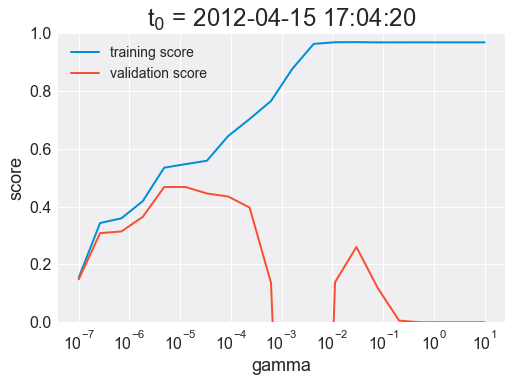

In [45]:
if plots_save_path:
    plt.style.use('jpm-light')
    plt.plot(gamma, np.median(train_score, 1), label='training score')
    plt.plot(gamma, np.median(val_score, 1), label='validation score')
    ax = plt.axes()
    plt.legend(loc='best')
    plt.title("t$_0$ = " + datetimeindex_to_human(light_curve_df.index)[0])
    ax.set_xscale('log')
    plt.xlabel('gamma')
    plt.ylabel('score')
    plt.ylim(0, 1);
    filename = plots_save_path + 'Validation Curve t0 ' + datetimeindex_to_human(light_curve_df.index)[0] + '.png'
    plt.savefig(filename)
    if verbose:
        logger.info("Validation curve saved to %s" % filename)

In [46]:
# Identify the best score
scores = np.median(val_score, axis=1)
best_fit_score = np.max(scores)
best_fit_gamma = gamma[np.argmax(scores)]
if verbose:
    logger.info('Scores: ' + str(scores))
    logger.info('Best score: ' + str(best_fit_score))
    logger.info('Best fit gamma: ' + str(best_fit_gamma))

# Return None if only got bad fits
if best_fit_score < minimum_score:
    if verbose:
        logger.warning("Uh oh. Best fit score {0:.2f} is < user-defined minimum score {1:.2f}".format(best_fit_score, minimum_score))
    #return None, best_fit_gamma, best_fit_score  # TODO: Uncomment for non-prototype

2017-12-01 16:05:41,145 [INFO ] [<module>] Scores: [  1.48370374e-01   3.08285871e-01   3.14149094e-01   3.64646882e-01
   4.67705064e-01   4.67863135e-01   4.45488691e-01   4.34812307e-01
   3.96777702e-01   1.36746528e-01  -1.64391348e+00  -2.03156379e+00
   1.38473269e-01   2.60309857e-01   1.18379052e-01   5.63339802e-03
   1.19454831e-06   2.22044605e-16   0.00000000e+00   0.00000000e+00]
2017-12-01 16:05:41,145 [INFO ] [<module>] Scores: [  1.48370374e-01   3.08285871e-01   3.14149094e-01   3.64646882e-01
   4.67705064e-01   4.67863135e-01   4.45488691e-01   4.34812307e-01
   3.96777702e-01   1.36746528e-01  -1.64391348e+00  -2.03156379e+00
   1.38473269e-01   2.60309857e-01   1.18379052e-01   5.63339802e-03
   1.19454831e-06   2.22044605e-16   0.00000000e+00   0.00000000e+00]
2017-12-01 16:05:41,148 [INFO ] [<module>] Best score: 0.467863135121
2017-12-01 16:05:41,148 [INFO ] [<module>] Best score: 0.467863135121
2017-12-01 16:05:41,149 [INFO ] [<module>] Best fit gamma: 1.27427

In [47]:
# Otherwise train and fit the best model
sample_weight = 1 / uncertainty
model = SVR(kernel='rbf', C=1e3, gamma=best_fit_gamma).fit(X, y, sample_weight)
y_fit = model.predict(X)

if verbose:
    logger.info("Best model trained and fitted.")

2017-12-01 16:05:41,369 [INFO ] [<module>] Best model trained and fitted.
2017-12-01 16:05:41,369 [INFO ] [<module>] Best model trained and fitted.


2017-12-01 16:05:41,593 [INFO ] [<module>] Fitted curve saved to ./Fit t0 2012-04-15 17:04:20.png
2017-12-01 16:05:41,593 [INFO ] [<module>] Fitted curve saved to ./Fit t0 2012-04-15 17:04:20.png


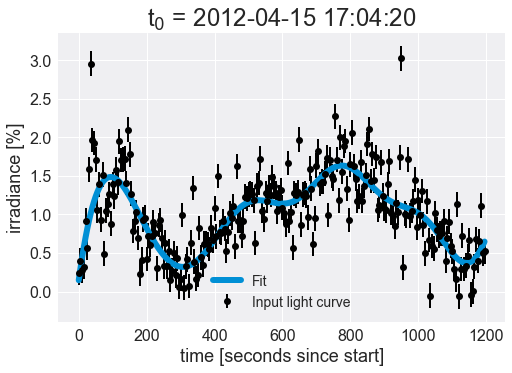

In [48]:
if plots_save_path:
    plt.errorbar(X.ravel(), y, yerr=uncertainty, color='black', fmt='o', label='Input light curve')
    plt.plot(X.ravel(), y_fit, linewidth=6, label='Fit')
    plt.title("t$_0$ = " + datetimeindex_to_human(light_curve_df.index)[0])
    plt.xlabel('time [seconds since start]')
    plt.ylabel('irradiance [%]')
    plt.legend(loc='best')
    filename = plots_save_path + 'Fit t0 ' + datetimeindex_to_human(light_curve_df.index)[0] + '.png'
    plt.savefig(filename)
    if verbose:
        logger.info("Fitted curve saved to %s" % filename)

In [49]:
# TODO: Get uncertainty of fit at each point... if that's even possible
# Placeholder for now just so that the function can complete: output uncertainty = input uncertainty
fit_uncertainty = uncertainty

In [50]:
# Construct a pandas DataFrame with DatetimeIndex, y_fit, and fit_uncertainty
light_curve_fit_df = pd.DataFrame({'irradiance': y_fit,
                                   'uncertainty': fit_uncertainty})
light_curve_fit_df.index = light_curve_df.index[finite_irradiance_indices]
if verbose:
    logger.info("Created output DataFrame")

2017-12-01 16:05:41,756 [INFO ] [<module>] Created output DataFrame
2017-12-01 16:05:41,756 [INFO ] [<module>] Created output DataFrame


In [52]:
return light_curve_fit_df, best_fit_gamma, best_fit_score

SyntaxError: 'return' outside function (<ipython-input-52-5fb2b30e6918>, line 1)